# Predicting CCS values for unimodal peptides

## Load best model

In [45]:
import sys
sys.path.append('/home/robbe/IM2DeepMulti')
sys.path.append('/home/robbe/IM2DeepMulti/IM2DeepMulti')
from datetime import datetime
from IM2DeepMulti.models import IM2DeepMultiTransferWithAttention, IM2DeepMultiTransfer
import IM2DeepMulti.utils


In [46]:
# Current best model
config = {
    "name": "BestPearsonBestModel",
    "time": datetime.now().strftime("%Y-%m-%d_%H-%M-%S"),
    "batch_size": 32,
    "learning_rate": 0.0000885185503354955,
    "diversity_weight": 1.2631492541307987,    # Should be high when using FlexibleLoss (4.2), much lower when using FlexibleLossSorted (1)
    "L1_alpha": 0.00000043707211872154, #0.00003 for FlexibleLoss, 0.02 for FlexibleLossSorted
    "epochs": 300,
    "delta": 0,
    "device": "1",
    "Use_best_model": True,
    "Add_branch_layer": False,
    'BranchSize': 28, #64 seems to be the best
    'Loss_type': 'FlexibleLoss',
    'Use_attention_output': True,
    'Use_attention_concat': True,
}

In [47]:
import torch
ckpt = torch.load('/home/robbe/IM2DeepMulti/checkpoints/BestModelAdaptedToNewArch.ckpt')

In [48]:
ckpt['state_dict']

{'backbone.ConvAtomComp.0.weight': tensor([[[ 4.5012e-02, -1.9761e-01,  9.1779e-02,  1.1656e-01],
          [ 3.8693e-02,  3.6002e-02, -5.9641e-02, -8.7149e-02],
          [-1.4178e-02,  1.3844e-01, -3.9418e-02,  1.8895e-01],
          [ 3.6641e-01, -9.2040e-02, -3.5896e-01, -2.1145e-01],
          [ 3.5915e-01,  3.4870e-01,  3.0847e-01, -1.0837e-01],
          [ 3.8836e-05, -7.9277e-06,  5.1705e-06,  2.1769e-05]],
 
         [[-6.6029e-02,  9.7514e-02,  1.6377e-01, -4.2185e-01],
          [-2.6929e-01,  1.0076e-01,  1.4304e-01, -2.4644e-01],
          [-3.5393e-01,  1.4500e-01,  2.3733e-01, -1.2179e-01],
          [-3.2654e-01, -2.5006e-02, -9.5414e-02, -4.1856e-02],
          [ 3.7489e-02, -1.4701e-01, -2.9160e-01,  1.2494e-01],
          [ 3.7527e-06, -5.6627e-06, -4.9707e-06, -1.5653e-05]],
 
         [[ 1.0980e-01, -2.7192e-01,  1.6941e-01,  2.6298e-02],
          [ 8.0829e-02,  1.7319e-01, -1.5622e-01,  7.8914e-02],
          [-6.3396e-02,  5.4179e-02, -3.9460e-01, -1.6296e-01],


In [49]:
criterion = IM2DeepMulti.utils.FlexibleLoss(config['diversity_weight'])
best_model = IM2DeepMultiTransferWithAttention.load_from_checkpoint('/home/robbe/IM2DeepMulti/checkpoints/BestModelAdaptedToNewArch.ckpt', config=config, criterion=criterion)


1335
480
20
6
1841


## Prepare data

In [50]:
import pickle
import numpy as np
ccs_df = pickle.load(open('/home/robbe/IM2DeepMulti/data/ccs_df_Unimodals.pkl', 'rb'))
AtomEnc = pickle.load(open('/home/robbe/IM2DeepMulti/data/AtomEnc-Unimodals.pickle', 'rb'))
Globals = pickle.load(open('/home/robbe/IM2DeepMulti/data/GlobalFeatures-Unimodals.pickle', 'rb'))
DiAminoAtomEnc = pickle.load(open('/home/robbe/IM2DeepMulti/data/DiAminoAtomEnc-Unimodals.pickle', 'rb'))
OneHot = pickle.load(open('/home/robbe/IM2DeepMulti/data/OneHot-Unimodals.pickle', 'rb'))
y = pickle.load(open('/home/robbe/IM2DeepMulti/data/y-Unimodals.pickle', 'rb'))
y = np.vstack(y)

AtomEnc = torch.tensor(AtomEnc, dtype=torch.float32).to(torch.device('cuda'))
Globals = torch.tensor(Globals, dtype=torch.float32).to(torch.device('cuda'))
DiAminoAtomEnc = torch.tensor(DiAminoAtomEnc, dtype=torch.float32).to(torch.device('cuda'))
OneHot = torch.tensor(OneHot, dtype=torch.float32).to(torch.device('cuda'))
y = torch.tensor(y, dtype=torch.float32).to(torch.device('cuda'))
dataset = torch.utils.data.TensorDataset(AtomEnc, DiAminoAtomEnc, Globals, OneHot, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'], shuffle=False)

## Predict

In [51]:
# Make predictions
best_model.eval()
with torch.no_grad():
    predictions = []
    for batch in dataloader:
        prediction = best_model.predict_step(batch)
        predictions.append(prediction)
    predictions = torch.cat(predictions, dim=0)

In [52]:
# Add predictions to ccs_df in two separate columns
ccs_df['Predicted CCS 1'] = predictions[:, 0].cpu().numpy()
ccs_df['Predicted CCS 2'] = predictions[:, 1].cpu().numpy()

In [53]:
# Get the closest prediction to the actual CCS
ccs_df['Closest predicted CCS'] = ccs_df.apply(lambda row: row['Predicted CCS 1'] if abs(row['Predicted CCS 1'] - row['CCS']) < abs(row['Predicted CCS 2'] - row['CCS']) else row['Predicted CCS 2'], axis=1)

In [54]:
ccs_df

,Modified sequence,charge,Conformer id total,CCS,between_brackets,seq,modifications,tr,Predicted CCS 1,Predicted CCS 2,Closest predicted CCS
0,(ac)AAAAAAAAAAGAAGGR,2,1.0,420.246235,Acetyl (Protein N-term,AAAAAAAAAAGAAGGR,0|Acetyl,0,413.135376,375.717072,413.135376
1,(ac)AAAAAAAAAAGDSDSWDADTFSMEDPVRK,3,1.0,684.779666,Acetyl (Protein N-term,AAAAAAAAAAGDSDSWDADTFSMEDPVRK,0|Acetyl,0,715.218567,664.308289,664.308289
2,(ac)AAAAAAAAEQQSSNGPVKK,2,1.0,493.777667,Acetyl (Protein N-term,AAAAAAAAEQQSSNGPVKK,0|Acetyl,0,504.415344,485.178345,485.178345
3,(ac)AAAAAAAGDSDSWDADAFSVEDPVRK,2,1.0,584.379228,Acetyl (Protein N-term,AAAAAAAGDSDSWDADAFSVEDPVRK,0|Acetyl,0,573.437866,551.819824,573.437866
4,(ac)AAAAAAAGDSDSWDADAFSVEDPVR,2,1.0,559.958995,Acetyl (Protein N-term,AAAAAAAGDSDSWDADAFSVEDPVR,0|Acetyl,0,546.994751,519.996155,546.994751
...,...,...,...,...,...,...,...,...,...,...,...
178377,YYYHYDLLR,2,1.0,400.187467,NaN,YYYHYDLLR,Not modified,0,403.122284,390.879120,403.122284
178378,YYYQGCASWK,2,1.0,397.738869,NaN,YYYQGCASWK,6|Carbamidomethyl,0,396.433105,385.149872,396.433105
178379,YYYVCQYCPAGNWANR,2,1.0,473.225416,NaN,YYYVCQYCPAGNWANR,5|Carbamidomethyl|8|Carbamidomethyl,0,486.635651,464.762421,464.762421
178380,YYYVPADFVEYEK,2,1.0,449.867302,NaN,YYYVPADFVEYEK,Not modified,0,455.279083,439.872711,455.279083


## Plot

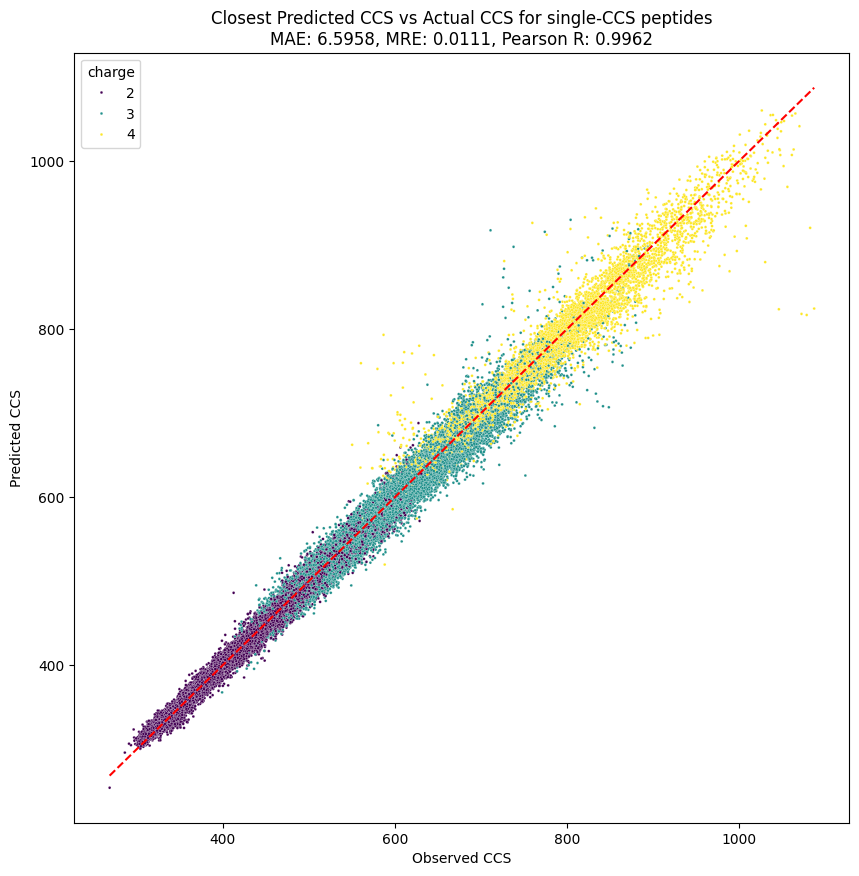

In [55]:
# Plot prediction accuracy
mae = abs(ccs_df['CCS'] - ccs_df['Closest predicted CCS']).mean()
mre = (abs(ccs_df['CCS'] - ccs_df['Closest predicted CCS']) / ccs_df['CCS']).median()
pearsonr = ccs_df['CCS'].corr(ccs_df['Closest predicted CCS'])
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.scatterplot(data=ccs_df, x='CCS', y='Closest predicted CCS', s=4, hue='charge', palette='viridis', ax=ax)
ax.plot([min(ccs_df['CCS']), max(ccs_df['CCS'])], [min(ccs_df['CCS']), max(ccs_df['CCS'])], color='red', linestyle='--')
ax.set_xlabel('Observed CCS')
ax.set_ylabel('Predicted CCS')
ax.set_title(f'Closest Predicted CCS vs Actual CCS for single-CCS peptides\nMAE: {mae:.4f}, MRE: {mre:.4f}, Pearson R: {pearsonr:.4f}')
plt.show()

# One-output prediction for the same peptides

In [56]:
BASEMODELCONFIG = {
        "AtomComp_kernel_size": 4,
        "DiatomComp_kernel_size": 4,
        "One_hot_kernel_size": 4,
        "AtomComp_out_channels_start": 356,
        "DiatomComp_out_channels_start": 65,
        "Global_units": 20,
        "OneHot_out_channels": 1,
        "Concat_units": 94,
        "AtomComp_MaxPool_kernel_size": 2,
        "DiatomComp_MaxPool_kernel_size": 2,
        "OneHot_MaxPool_kernel_size": 10,
        "LRelu_negative_slope": 0.013545684190756122,
        "LRelu_saturation": 40,
        }

In [57]:
from IM2DeepMulti.models import IM2Deep
unimodal_model = IM2Deep(BASEMODELCONFIG)
unimodal_model.load_state_dict(torch.load('/home/robbe/IM2DeepMulti/BestParams_final_model_state_dict.pth'))
unimodal_model.to(torch.device('cuda'))
unimodal_model.eval()
with torch.no_grad():
    predictions = []
    for batch in dataloader:
        atom_enc, diatom_enc, global_enc, one_hot, y = batch
        prediction = unimodal_model(atom_enc, diatom_enc, global_enc, one_hot)
        predictions.append(prediction)
    predictions = torch.cat(predictions, dim=0)

1335
480
20
6
1841


In [58]:
ccs_df['Unimodal Predicted CCS'] = predictions.cpu().numpy()

In [59]:
# Plot prediction accuracy of multimodal vs unimodal model
mae_multi = abs(ccs_df['CCS'] - ccs_df['Closest predicted CCS']).mean()
mre_multi = (abs(ccs_df['CCS'] - ccs_df['Closest predicted CCS']) / ccs_df['CCS']).median()
pearsonr_multi = ccs_df['CCS'].corr(ccs_df['Closest predicted CCS'])

mae_uni = abs(ccs_df['CCS'] - ccs_df['Unimodal Predicted CCS']).mean()
mre_uni = (abs(ccs_df['CCS'] - ccs_df['Unimodal Predicted CCS']) / ccs_df['CCS']).median()
pearsonr_uni = ccs_df['CCS'].corr(ccs_df['Unimodal Predicted CCS'])

print(f'Multimodal model: MAE: {mae_multi:.4f}, MRE: {mre_multi:.4f}, Pearson R: {pearsonr_multi:.4f}')
print(f'Unimodal model: MAE: {mae_uni:.4f}, MRE: {mre_uni:.4f}, Pearson R: {pearsonr_uni:.4f}')


Multimodal model: MAE: 6.5958, MRE: 0.0111, Pearson R: 0.9962
Unimodal model: MAE: 14.0585, MRE: 0.0267, Pearson R: 0.9948
